In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
# make as Class
class NNCLassifier:

        
    def fit(self,seed):
        np.random.seed(seed)
        X= np.vstack((np.random.uniform(-10,10, 20000),np.random.uniform(-10,10, 20000),np.random.uniform(-10,10, 20000),
                      np.random.normal(0,np.sqrt(10), 20000),np.random.normal(0,np.sqrt(10), 20000),np.random.normal(0,np.sqrt(10), 20000),np.random.normal(0,np.sqrt(10), 20000)))
        X = np.transpose(X)

        # generating p
        p = 1/(1 + np.exp(-(X[:,0] * np.sqrt(np.abs(X[:,3])+1) + np.sin(X[:,2]) - np.abs(X[:,1]) / np.sqrt(np.abs(X[:,4])+1) + 1.5 * np.abs(X[:,5]) + X[:,6])))
    
        # generating y
        np.random.seed(seed)
        y = np.random.binomial(1,p,len(p))
        
        # split data into train and test
        X_tr = X[:10000,:] ; X_tst = X[10000:,:]
        y_tr = y[:10000] ; y_tst = y[10000:]
        self.X_tr = X_tr ; self.X_tst = X_tst
        self.y_tr = y_tr ; self.y_tst = y_tst
        self.ytype = np.sort(np.unique(y_tr))
        
        # Make cases of hidden layer and hidden node
        Layer = [1,2,3,4]
        Node = [2,3,4,5]

        AUROCs = np.zeros((len(Layer),len(Node)))
        
        
        # fit nn model
        AUROCs = np.zeros((len(Layer),len(Node)))
        pred_nn = []
        for l in range(len(Layer)):
            for n in range(len(Node)):
                model = MLPClassifier(hidden_layer_sizes=np.repeat(Node[n],Layer[l]))
                model.fit(X_tr, y_tr)
                auroc = roc_auc_score(y_tst,model.predict_proba(X_tst)[:,1])
                AUROCs[l,n] = auroc
                pred_nn.append(model.predict(X_tst))
                
        best_layer = int(np.argmax(AUROCs) / AUROCs.shape[1])
        best_node = np.argmax(AUROCs) % AUROCs.shape[1]
        AUROCs[best_layer,best_node]
        print(f' Best number of Layer : {Layer[best_layer]} \n Best number of Node : {Node[best_node]} \n AUROC is {AUROCs[best_layer,best_node]}')
        self.layer = Layer[best_layer]
        self.node = Node[best_node]
        self.pred_y = pred_nn[np.argmax(AUROCs)]
        
    def predict(self):
        y_tst = self.y_tst
        pred_y = self.pred_y
        result = pd.DataFrame()
        result['Actual Class'] = y_tst
        result['Predicted Class'] = pred_y
        return result
    
    def confusion_matrix_acc(self):
        ytype = self.ytype
        result = self.predict()

        #confusion matrix of linear svm
        C = []
        for i in range(len(ytype)):
            for j in range(len(ytype)):
                C.append(((result['Actual Class'] == ytype[i]) & (result['Predicted Class'] == ytype[j])).sum())

        C_2 = pd.DataFrame(np.array(C).reshape(len(ytype),len(ytype)),
                          index = ytype, columns = ytype)
        acc = round(np.diag(C_2).sum()/C_2.sum().sum(),3)
        
        return C_2, acc

    
    def print_result(self):
        out_name = input("Enter the output file name to export [(ex) result.txt] : ")
        C_2, acc = self.confusion_matrix_acc()
        
        C_2.to_csv('temp2.txt', sep = '\t')
        temp2 = []
        temp2.append('\tPredicted Class \n')
        r = open('temp2.txt','r')
        for line in r.readlines():
            temp2.append(line)
        r.close()    
        for i in range(len(temp2)):
            if i == 2:
                temp2[i] = 'Actual \t' + temp2[i]+ '\n'
            elif i == 3:
                temp2[i] = 'Class \t' + temp2[i]+ '\n'
            else:
                temp2[i] = '\t' + temp2[i]+ '\n'

        f = open(out_name, 'w+')
        f.write('Confusion Matrix (NN) \n')
        f.write('---------------------------------\n')
        for line in temp2:
            f.write(line)
        f.write('\n')
        f.write('Model Summary (NN) \n')
        f.write('---------------------------------\n')
        f.write(f'Overall accuracy = {acc}')
        f.close()

        r = open(out_name,'r')
        for line in r.readlines():
            print(line)
        r.close()
        os.remove('temp2.txt')        
        
    def diagram(self):
        layer = self.layer
        node = self.node

        # make all layer architect
        all_layer = []
        all_layer.append(self.X_tr.shape[1])
        for i in range(layer):
            all_layer.append(node)
        all_layer.append(1)

        # diagram
        fig = plt.figure(figsize = (12,12))
        ax = fig.gca()
        ax.axis('off')
        self.__draw_neural_net(ax,0.1,0.9,0.1,0.9,all_layer)
        ax.text(0.045,0.95,'input layer',size = 'xx-large')
        ax.text(0.4,0.95,'hidden layer',size = 'xx-large')
        ax.text(0.82,0.95,'output layer',size = 'xx-large')
        ax.axvline(x = 0.2, ymin = 0.1, ymax = 0.9, c = 'red', ls = '--')
        ax.axvline(x = 0.8, ymin = 0.1, ymax = 0.9, c = 'red', ls = '--')

    def __draw_neural_net(self,ax, left, right, bottom, top, layer_sizes):
        '''
        Draw a neural network cartoon using matplotilb.

        :usage:
            >>> fig = plt.figure(figsize=(12, 12))
            >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

        :parameters:
            - ax : matplotlib.axes.AxesSubplot
                The axes on which to plot the cartoon (get e.g. by plt.gca())
            - left : float
                The center of the leftmost node(s) will be placed here
            - right : float
                The center of the rightmost node(s) will be placed here
            - bottom : float
                The center of the bottommost node(s) will be placed here
            - top : float
                The center of the topmost node(s) will be placed here
            - layer_sizes : list of int
                List of layer sizes, including input and output dimensionality
        '''
        n_layers = len(layer_sizes)
        v_spacing = (top - bottom)/float(max(layer_sizes))
        h_spacing = (right - left)/float(len(layer_sizes) - 1)
        # Nodes
        for n, layer_size in enumerate(layer_sizes):
            layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
            for m in range(layer_size):
                circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                    color='w', ec='k', zorder=4)
                ax.add_artist(circle)
        # Edges
        for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
            for m in range(layer_size_a):
                for o in range(layer_size_b):
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                    ax.add_artist(line)


In [3]:
nnmodel = NNCLassifier()

In [4]:
nnmodel.fit(1)

/Users/hyeonki/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyeonki/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyeonki/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyeonki/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyeonki/o

 Best number of Layer : 2 
 Best number of Node : 5 
 AUROC is 0.9938290316714633


In [5]:
nnmodel.print_result()

Enter the output file name to export [(ex) result.txt] :  result.txt


Confusion Matrix (NN) 

---------------------------------

		Predicted Class 



		0	1



Actual 	0	4484	200



Class 	1	199	5117





Model Summary (NN) 

---------------------------------

Overall accuracy = 0.96


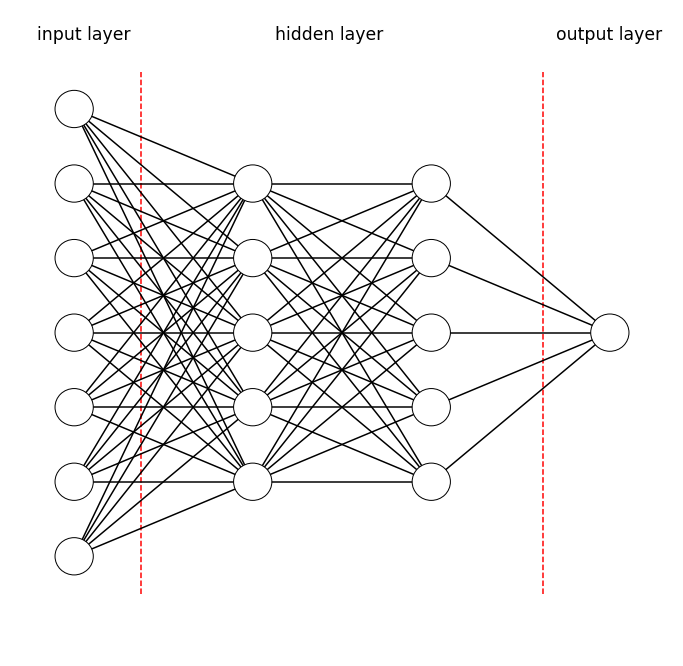

In [6]:
nnmodel.diagram()